In [1]:
import pandas as pd
import seaborn as sns
from hepler import *
from modeling_pipelines import *
import joblib

# sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import FixedThresholdClassifier
from sklearn.inspection import permutation_importance

# tune
import optuna

optuna.logging.set_verbosity(optuna.logging.INFO)

# vis
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import DiscriminationThreshold

# display
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_style("darkgrid")

#### 🎯Notebook Goal

1. Train and tune different models using selected features.
2. Compare trained models with base model which is only trained with application_data.
3. Select candidate models and tune thresholds.
4. Feature Importance and error analysis.
5. Decide on the best model to deploy.

In [8]:
X_train = joblib.load("data/X_train").reset_index()
X_val = joblib.load("data/X_val").reset_index()
y_train = joblib.load("data/y_train")
y_val = joblib.load("data/y_val")

# Train and val data with app only features
X_train_app = cast_typ_obj_to_cat(joblib.load("data/X_train_cleaned"))
X_val_app = cast_typ_obj_to_cat(joblib.load("data/X_val_cleaned"))

X_train = merge_selected_app_and_historical_feats(X_train)
X_val = merge_selected_app_and_historical_feats(X_val)
assert X_train.shape == (230633, 71), "X_train_misshaped"

Stratify cv splits for nested cv

In [3]:
tuning_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model_selection_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

#### Train and tune models with Optuna

Our target is highly imbalanced, with 
- 92% of data being no-default
- 8% of data being default

Threshold agnostic metric `ROC AUC` is used for hyperparameter tuning and model \
evaluation.

Try out different models and different balancing strategy, train the models on \
selected features which contains application and credit history features.

1. `LGBM with class_balance`.
2. `LGBM with SMOTE` (over sampling).
3. `Logistic Regression with class_balance`.
4. `Balanced RandomForest from imblearn`.
5. `Voting Classifier combining LGBM + Balanced RandomForest`.

Compare with `Base Model, which is a LGBM model trained only on application data`. 

Can our models out-perform the Base Model ?

In [ ]:
base_model = tuned_model(
    "base_model", app_lgbm_balanced_pipeline, X_train_app, y_train, tuning_cv
)

In [ ]:
base_model = tuned_model('base_model', app_lgbm_balanced_pipeline, X_train_app, y_train, tuning_cv)
lgbm_model = tuned_model('lgbm_model', lgbm_balanced_pipeline, X_train, y_train, tuning_cv)
lgbm_smote_model = tuned_model('lgbm_smote_model', lgbm_smote_pipeline, X_train, y_train, tuning_cv)
balanced_rf_model = tuned_model('balanced_rf', balanced_rf_pipeline, X_train, y_train, tuning_cv)
logit_model = tuned_model('logit_model', logit_pipeline, X_train, y_train, tuning_cv)
vote_model = VotingClassifier(
    estimators=[("lgbm", lgbm_model), ("balanced_rf", balanced_rf_model)], voting="soft"
).fit(X_train, y_train)


#### Cross validation on validation dataset

In [17]:
base_cv = get_cv_score(base_model, X_val_app, y_val)
balanced_rf_cv = get_cv_score(balanced_rf_model, X_val, y_val)
lgbm_cv = get_cv_score(lgbm_model, X_val, y_val)
lgbm_smote_cv = get_cv_score(lgbm_smote_model, X_val, y_val)
logit_cv = get_cv_score(logit_model, X_val, y_val)
vote_cv = get_cv_score(vote_model, X_val, y_val)

model_cv_df = pd.DataFrame(
    [base_cv, balanced_rf_cv, vote_cv, lgbm_cv, lgbm_smote_cv, logit_cv],
    index=["base", "balanced_rf", "lgbm+balanced_rf", "lgbm", "lgbm_smote", "logit"],
).reset_index()

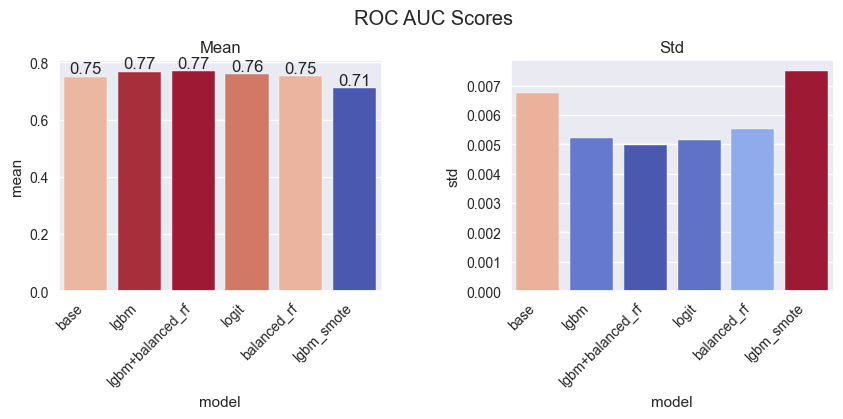

In [21]:
fig_size(10, 3)
plt.subplot(1, 2, 1)

ax = sns.barplot(
    data=model_cv_df,
    x="index",
    y="mean",
    hue="mean",
    palette="coolwarm",
    order=["base", "lgbm", "lgbm+balanced_rf", "logit", "balanced_rf", "lgbm_smote"],
)
plt.legend("")
plt.title("Mean")
plt.xlabel("model")
plt.xticks(rotation=45, ha="right")

mark_bar(ax)

plt.subplot(1, 2, 2)
ax = sns.barplot(
    data=model_cv_df,
    x="index",
    y="std",
    hue="std",
    palette="coolwarm",
    order=["base", "lgbm", "lgbm+balanced_rf", "logit", "balanced_rf", "lgbm_smote"],
)
plt.legend("")
plt.xlabel("model")
plt.xticks(rotation=45, ha="right")
plt.title("Std")
plt.suptitle("ROC AUC Scores", y=1.05)
plt.subplots_adjust(wspace=0.4)
plt.show()

📝 ROC AUC score comparison

Base LGBM model trained without historical credit data is already very performant. \
The same LGBM model trained on application + historical data performs slightly \
better with higher ROC mean and lower standard deviation.

Balanced RandomForest and Logit have similar score, while LGBM + SMOTE has the \
worst score of all.

The voting model (LGBM + Balanced_rf) has the same score as LGBM model with slightly \
lower std, voting has increased the robustness.



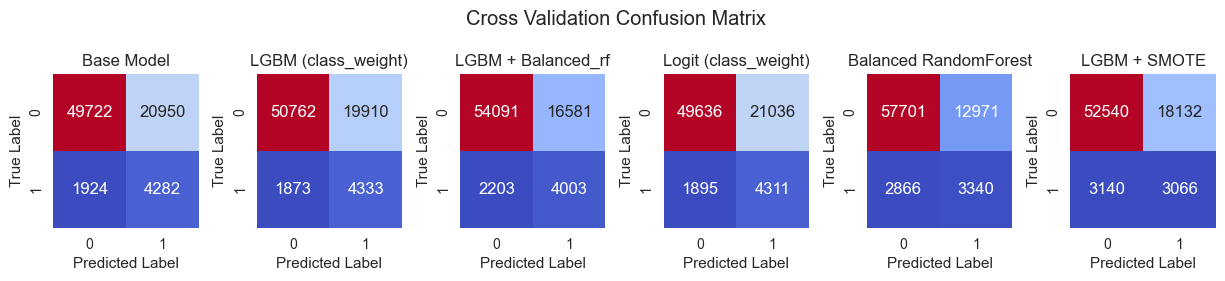

In [22]:
y_pred_base = base_model.predict(X_val_app)
y_pred_lgbm = lgbm_model.predict(X_val)
y_pred_logit = logit_model.predict(X_val)
y_pred_balanced_rf = balanced_rf_model.predict(X_val)
y_pred_lgbm_smote = lgbm_smote_model.predict(X_val)
y_pred_vote = vote_model.predict(X_val)
# confusion matrix
fig_size(15, 2)

plt.subplot(1, 6, 1)
plot_confusion(y_pred_base, y_val, "Base Model")

plt.subplot(1, 6, 2)
plot_confusion(y_pred_lgbm, y_val, "LGBM (class_weight)")

plt.subplot(1, 6, 3)
plot_confusion(y_pred_vote, y_val, "LGBM + Balanced_rf")

plt.subplot(1, 6, 4)
plot_confusion(y_pred_logit, y_val, "Logit (class_weight)")

plt.subplot(1, 6, 5)
plot_confusion(y_pred_balanced_rf, y_val, "Balanced RandomForest")

plt.subplot(1, 6, 6)
plot_confusion(y_pred_lgbm_smote, y_val, "LGBM + SMOTE")

plt.subplots_adjust(wspace=0.4)
plt.suptitle("Cross Validation Confusion Matrix", y=1.2)
plt.show()

📝 Cross Validation Confusion Matrix

Confusion matrix tell us even more story about the prediction.

Comparing to the base model:

- `LGBM model` trained with full data has better recall and precision on both \
classes. The main improvement lies in class 0 which has 2 % increase in recall, \
while the recall of class 1 is very similar.

- `Logit model` has very similar metrics as Base model.

- `BalancedRandomForest model` has very high recall improvement on class 0 (16 % ), \
but worse recall in class 1 (-30%).

💡 BalancedRandomForest and LGBM have their own strength and makes different \
kind of mistake (fp/fn), thus I used them to created the Vote model.

(I've tried to play with the weight of the 2 models in VotingClassifier, but \
I think using the same weight is a good balance.)

- For `Vote model combining LGBM + BalancedRandomForest`, the recall \
of class 1 is 6% worse than the base model, but the recall of class 0 has 8% \
improvement. Since the majority (92%) of applicants are in class 0, although it \
is not the most performant in all metrics, it is still a good candidate.

Going forward, we would pay more attention to the 2 most promising models: 
- LGBM
- Vote Model (LGBM + Balanced RandomForest).

📊 ROC AUC Curve

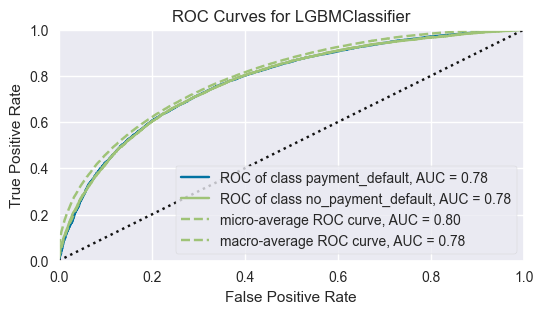

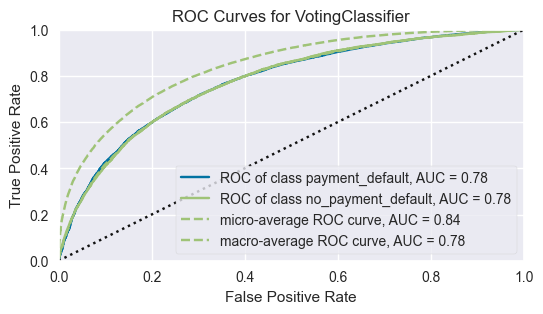

In [10]:
fig_size(6, 3)
visualizer = ROCAUC(lgbm_model, classes=["payment_default", "no_payment_default"])
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
visualizer.show()

fig_size(6, 3)
visualizer = ROCAUC(vote_model, classes=["payment_default", "no_payment_default"])
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
visualizer.show()

plt.show()

📝 We can observe from the ROC curve that LGBM is a balanced model with similar \
micro and macro average while Vote Model is more performant looking at \
micro-average ROC. 

#### Threshold Tuning

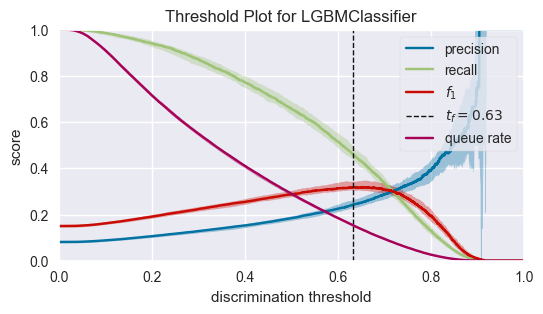

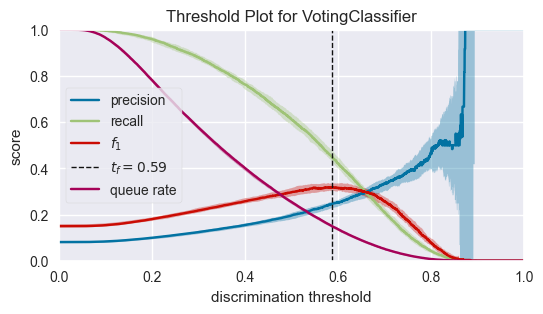

<Axes: title={'center': 'Threshold Plot for VotingClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [27]:
fig_size(6, 3)
visualizer = DiscriminationThreshold(lgbm_model)
visualizer.fit(X_val, y_val)
visualizer.show()

fig_size(6, 3)
visualizer = DiscriminationThreshold(vote_model)
visualizer.fit(X_val, y_val)
visualizer.show()
plt.show

##### Tune thresholds lightly to observe the impact on confusion matrix.

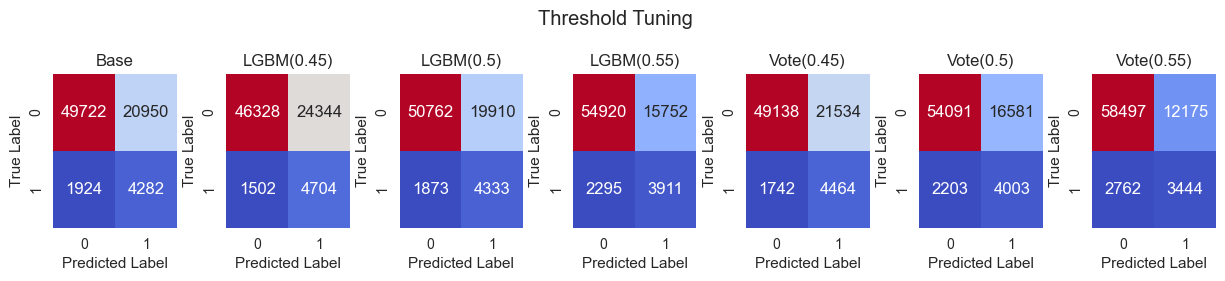

In [13]:
# classifier
lgbm_model_thres_big = FixedThresholdClassifier(lgbm_model, threshold=0.55)
lgbm_model_thres_small = FixedThresholdClassifier(lgbm_model, threshold=0.45)
vote_model_thres_big = FixedThresholdClassifier(vote_model, threshold=0.55)
vote_model_thres_small = FixedThresholdClassifier(vote_model, threshold=0.45)
# fit
lgbm_model_thres_big.fit(X_train, y_train)
lgbm_model_thres_small.fit(X_train, y_train)
vote_model_thres_big.fit(X_train, y_train)
vote_model_thres_small.fit(X_train, y_train)
# pred
lgbm_thres_big = lgbm_model_thres_big.predict(X_val)
lgbm_thres_small = lgbm_model_thres_small.predict(X_val)
vote_thres_big = vote_model_thres_big.predict(X_val)
vote_thres_small = vote_model_thres_small.predict(X_val)

fig_size(15, 2)
plt.subplot(1, 7, 1)
plot_confusion(y_pred_base, y_val, "Base")
plt.subplot(1, 7, 2)
plot_confusion(lgbm_thres_small, y_val, "LGBM(0.45)")
plt.subplot(1, 7, 3)
plot_confusion(y_pred_lgbm, y_val, "LGBM(0.5)")

plt.subplot(1, 7, 4)
plot_confusion(lgbm_thres_big, y_val, "LGBM(0.55)")
plt.subplot(1, 7, 5)
plot_confusion(vote_thres_small, y_val, "Vote(0.45)")
plt.subplot(1, 7, 6)
plot_confusion(y_pred_vote, y_val, "Vote(0.5)")
plt.subplot(1, 7, 7)
plot_confusion(vote_thres_big, y_val, "Vote(0.55)")

plt.subplots_adjust(wspace=0.4)
plt.suptitle("Threshold Tuning", y=1.2)
plt.show()

📝 Comparing models with different thresholds

Tuning the threshold of LGBM and Vote models here do not yield any model that \
performs significantly better or worse, we can see the trade-offs of each threshold.

#### Feature Importance and Error Analysis

##### Permutation Feature Importance

In [111]:
lgbm_p_imp = permutation_importance(
    lgbm_model, X_val, y_val, n_repeats=10, random_state=0, n_jobs=-1
)
vote_p_imp = permutation_importance(
    vote_model, X_val, y_val, n_repeats=10, random_state=0, n_jobs=-1
)

col_names = X_val.columns.tolist()
permutation_imp = pd.DataFrame()
permutation_imp["lgbm"] = lgbm_p_imp.importances_mean
permutation_imp["vote"] = vote_p_imp.importances_mean
permutation_imp["index"] = col_names
permutation_imp = permutation_imp.set_index("index")

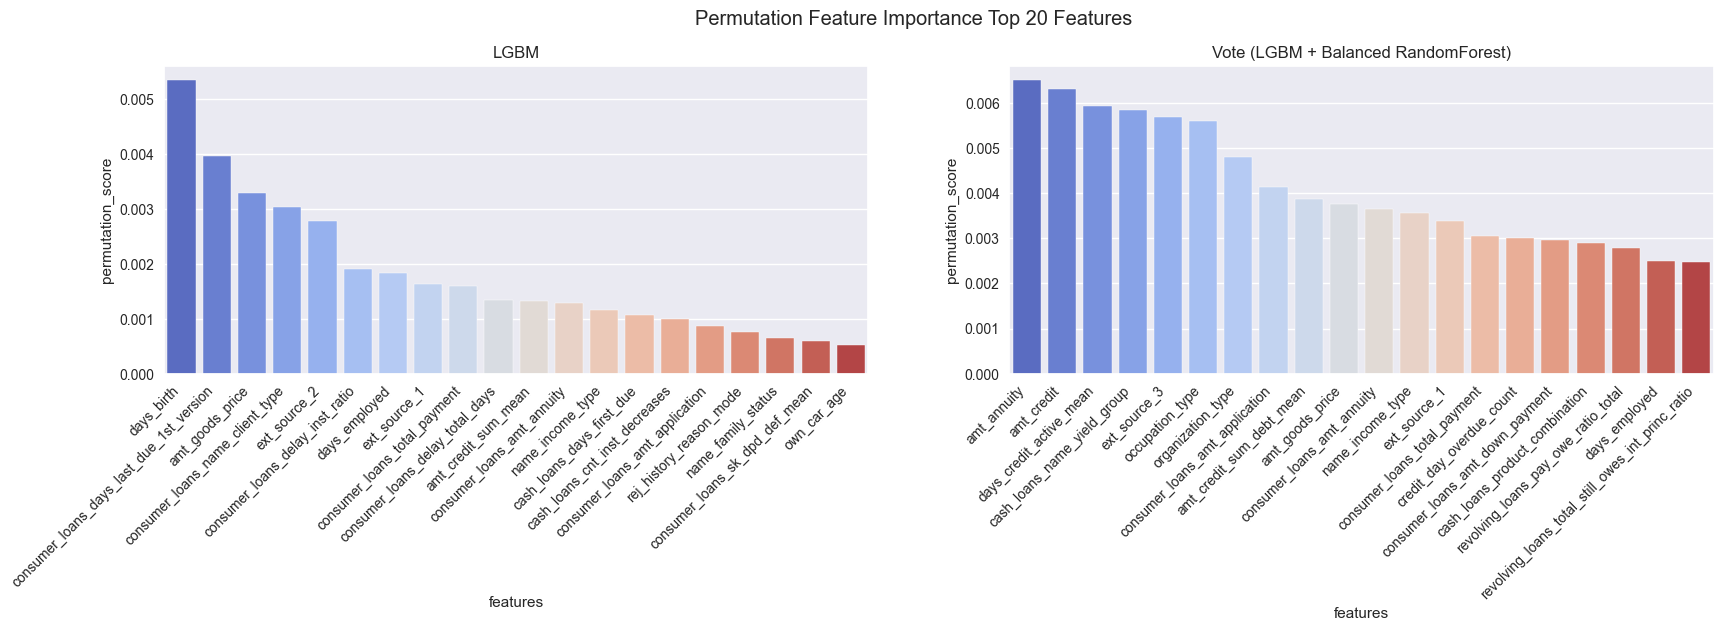

In [117]:
fig_size(20, 4)
plt.subplot(1, 2, 1)
sns.barplot(
    data=permutation_imp.sort_values(by="lgbm", ascending=False).lgbm[:20],
    palette="coolwarm",
)

plt.xticks(rotation=45, ha="right")
plt.title("LGBM")
plt.xlabel("features")
plt.ylabel("permutation_score")

plt.subplot(1, 2, 2)
sns.barplot(
    data=(-1 * permutation_imp).sort_values(by="vote", ascending=False).vote[:20],
    palette="coolwarm",
)
plt.xticks(rotation=45, ha="right")
plt.title("Vote (LGBM + Balanced RandomForest)")
plt.xlabel("features")
plt.ylabel("permutation_score")

plt.suptitle("Permutation Feature Importance Top 20 Features", y=1.02)
plt.show()

📝 Permutation Feature Importance of LGBM and Vote (LGBM + BalancedRF) model

Out of the top 20 features, there are 7 overlaps, and the importance orders are \
different. 

In the Vote model, current application related data has higher permutation \
importance than historical features, while the importance of application and \
historical data is more balanced in the LGBM model.

##### Error Analysis: 

There's no one model which has all metrics out performing the others, \
what are the trade-offs of the candidate models ? 

Here we look at one feature that impacts the financial institution/ banks most \
directly: `Loan amount credit`.

> We compare the amt_credit of false postive and false negatives of the 3 models, \
`LGBM`, `BalancedRF`, `LGBM + BalancedRF`

All models make mistakes, which kind of mistake to which extent is worse than \
the others ? aka: Which kind of mistake is going to cost the bank more ?

In [66]:
y_pred_lgbm = lgbm_model.predict(X_val)
y_pred_vote = vote_model.predict(X_val)
y_pred_brf = balanced_rf_model.predict(X_val)

lgbm_val_df = X_val.copy()
vote_val_df = X_val.copy()
brf_val_df = X_val.copy()

lgbm_val_df["res"] = get_classification_result(y_val, y_pred_lgbm)
vote_val_df["res"] = get_classification_result(y_val, y_pred_vote)
brf_val_df["res"] = get_classification_result(y_val, y_pred_brf)

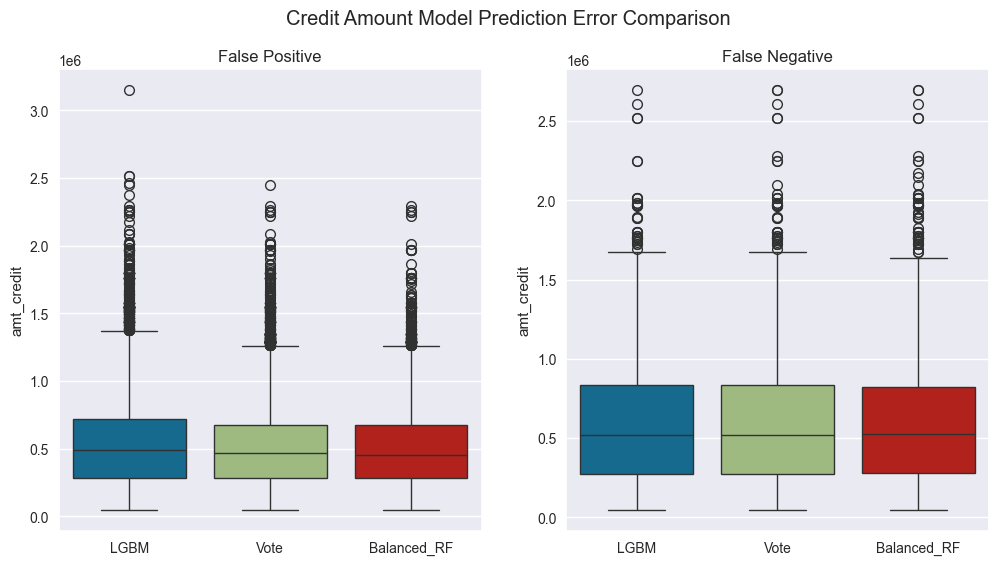

,LGBM_fp,Vote_fp,Balanced_RF_fp,LGBM_fn,Vote_fn,Balanced_RF_fn
count,19910.000000,16581.000000,12971.000000,1873.000000,2203.000000,2866.000000
mean,546734.500000,527785.310000,510851.530000,613514.310000,615274.940000,612884.560000
std,332324.470000,308563.380000,285335.660000,413111.030000,415440.910000,408199.530000
min,45000.000000,45000.000000,47970.000000,45000.000000,45000.000000,45000.000000
25%,284400.000000,284400.000000,284400.000000,270000.000000,270000.000000,276277.500000
50%,489024.000000,468733.500000,454500.000000,521280.000000,521280.000000,525492.000000
75%,720000.000000,675000.000000,675000.000000,835380.000000,835380.000000,824823.000000
max,3150000.000000,2448000.000000,2295778.500000,2695500.000000,2695500.000000,2695500.000000


In [99]:
fig_size(12, 6)
plt.subplot(1, 2, 1)
sns.boxplot(
    {
        "LGBM": lgbm_val_df.loc[lgbm_val_df.res == "fp"].amt_credit,
        "Vote": vote_val_df.loc[vote_val_df.res == "fp"].amt_credit,
        "Balanced_RF": brf_val_df.loc[brf_val_df.res == "fp"].amt_credit,
    }
)
plt.ylabel("amt_credit")
plt.title("False Positive")

plt.subplot(1, 2, 2)
sns.boxplot(
    {
        "LGBM": lgbm_val_df.loc[lgbm_val_df.res == "fn"].amt_credit,
        "Vote": vote_val_df.loc[vote_val_df.res == "fn"].amt_credit,
        "Balanced_RF": brf_val_df.loc[brf_val_df.res == "fn"].amt_credit,
    }
)
plt.ylabel("amt_credit")
plt.title("False Negative")
plt.suptitle("Credit Amount Model Prediction Error Comparison")

plt.show()

error_df = (
    pd.DataFrame(
        {
            "LGBM_fp": lgbm_val_df.loc[lgbm_val_df.res == "fp"].amt_credit,
            "Vote_fp": vote_val_df.loc[vote_val_df.res == "fp"].amt_credit,
            "Balanced_RF_fp": brf_val_df.loc[brf_val_df.res == "fp"].amt_credit,
            "LGBM_fn": lgbm_val_df.loc[lgbm_val_df.res == "fn"].amt_credit,
            "Vote_fn": vote_val_df.loc[vote_val_df.res == "fn"].amt_credit,
            "Balanced_RF_fn": brf_val_df.loc[brf_val_df.res == "fn"].amt_credit,
        }
    )
    .describe()
    .round(2)
    .style.apply(mark_df_color, id=5)
)

error_df

📝 Loan Credit Model Errors Comparison

__False_Positive__
- LGBM is more strict in identifying positive class,, the median and mean of LGBM \
is 20,000 higher than the Vote model. It has higher chance to falsely predict \
default on people who apply for bigger loans.
> This is not ideal for our use case, since banks can earn more interest from \
bigger loans, they would earn less if more of the bigger loans are rejected.

__False_Negative__
- The mean and median of LGBM and Vote model is very similar while the Balanced_RF \
has bigger median. This means that, for the loans that are falsely predicted as \
default, the loan credit in LGBM and Vote model are similar. 

> Despite of being more tolerant, Vote model is not falsely predicting big loan_amt \
to not_default, but the smaller loans.

🏦 Final Decision 🏦

Based on our analysis on `LGBM` and `LGBM + Balanced_RF model`, from Home Credit \
Group perspective, 

> I would recommend ` Vote (LGBM + Balanced_RF)` model for several reasons:

1. Application related features have higher importance in vote model. Since Home Credit \
Group is mainly offering loans to people with little credit history, a model that \
uses less historical credit features would be more robust and create less bias \
across a mixed group of clients in which majority of them have little credit history.

2. Although the model identifies less loan_default, the ones it miss have no \
bigger loan amount than the ones missed by LGBM. This implies that unreasonably \
big loans or people with bad records are still captured (marked as default). 

3. The model is more tolerant, it successfully predicts almost 10% more loans to \
non-default, considering that 92% of applicants are non defaulters, this is a very \
big group of people. Based on this, banks can thus provide service to more people \
and earn interest from them.

🚀 The Vote Model is deployed ! 

Test it out in the `prediction_demo.ipynb` notebook.

✅ Improvements:

1. Establishing a modeling and deployment pipeline early on is essential for \
receiving performance feedback sooner in the process.

2. Addressing memory constraints will accelerate code execution and enable testing \
of additional features using automated tools like featuretools.

2. Enhancing the containerization process can streamline deployment and operation \
further.